# Terzaghi's consolidation problem

This notebook shows how to set up Terzaghi's consolidation problem using MPFA/MPSA-FV by
inhereting from the `ContactMechanicsBiot` model class.

In addition, we will also learn to:
* Set up roller boundary conditions for the mechanical (sub)problem.
* Employ variable time steps using the time-stepping control routine to match desired scheduled times.

Recommended previous examples:
* Manufactured solution for Biot's problem

Related examples:
* Mandel's problem

## Description of the problem

Terzaghi's problem is a well known one-dimensional consolidation process [[1-2](#References)].
Generally, when soils are subjected to a vertical load, porosity decreases, resulting in less
available space for pore water. The liquid within the pores can be expelled, however, in certain
types of soils (especially clayey soils) this process may take some time due to their low
permeability. This process is referred to as _consolidation_.

We consider a soil column of height $h$ (see left figure from below). We apply a
constant load $F$ to the top of the column while keeping the bottom impervious to flow. The
exherted load will cause an instantaneous rise in the fluid pressure, which will be equal to the
applied load. After that, the fluid pressure will montonically decrease to zero.

In order to emulate the one-dimensional consolidation process using a two-dimensional domain,
on the sides of domain, we use impose roller boundary conditions for the mechanics and no-flux
for the flow subproblems, respectively. We therefore expect the horizontal component of the
displacement to be zero at all times.

<img src="fig/domain_and_bc.svg" alt="Terzaghi's consolidation problem" style="width: 600px;"/>

## The analytical solution

The analytical solution to Terzaghi's consolidation can be found in [[3](#References)]. The
pressure distribution reads:

\begin{equation}
    p(y,t) = \frac{4}{\pi} p_0 \sum_{j=1}^{\infty} \frac{(-1)^{j-1}}{2j-1} \cos
    \left[(2j-1)\frac{\pi}{2}\frac{y}{h} \right] \exp
    \left[-(2j-1)^2 \frac{\pi^2}{4} \frac{c_f t}{h^2} \right],
\end{equation}

where $p_0 = p(y,0) = F$ and $c_f$ is the so-called _coefficient of consolidation_.

The mechanical effects can be studied introducing the concept of _degree of consolidation_, a
dimensionless measure of the state of consolidation, ranging from $0$ (for an unconsolidated
state) to $1$ (for a fully consolidated state). The degree of consolidation is given by:

\begin{equation}
    U(t) = \frac{u_y - u_{y,0}}{u_{y,\infty} - u_{y,0}} = 1 - \frac{8}{\pi^2}
    \sum_{k=1}^{\infty} \frac{1}{(2k-1)^2}
\exp\left[-(2k-1)^2 \frac{\pi^2}{4} \frac{c_f t}{h^2}\right],
\end{equation}

where $u_{y,\infty} = {hF}/({2\mu_s + \lambda_s})$ is the final vertical displacement and
$u_{y,0} = 0$ is the initial displacement. The parameters $\mu_s$ and $\lambda_s$ are the usual
Lamé parameters.

## Model setup and physical parameters

The adopted domain will be a unit square $\Omega = (0,1)^2~\mathrm{m}^2$ for a final simulation
time $T = 600~\mathrm{s}$. The domain is discretized in space using an unstuctured triangular
grid. To capture the entire consolidation process, we employ a varying time-stepping strategy
 using the class `pp.TimeSteppingControl` available in PorePy. We will develop on this later.

The physical parameters used in the simulation are listed below:

**Parameter** | **Symbol** | **Value** | **Unit**
----------:|:----------:|:----------:|:----------:
First Lamé parameter| $\lambda_s$ | $1$ | $\mathrm{Pa}$
Second Lamé parameter| $\mu_s$ | $1$ | $\mathrm{Pa}$
Intrinsic permeability | $\mathbf{k}$ | $0.001\mathbf{I}$ | $\mathrm{m^2}$
Fluid density | $\rho_f$ | $1$ | $\mathrm{m^3}$
Fluid viscosity | $\mu_f$ | $1$ | $\mathrm{Pa \cdot s}$ 
Storativity | $S_\varepsilon$ | $0$ | $\mathrm{Pa^{-1}}$
Biot coefficient | $\alpha$ | $1$ | $\mathrm{-}$
Aplied load | $F$ | $1$ | $\mathrm{N}$

## References

[1] von Terzaghi, K. (1923). Die berechnung der durchassigkeitsziffer des tones aus dem verlauf
der hydrodynamischen spannungs. erscheinungen. Sitzungsber. Akad. Wiss. Math. Naturwiss. Kl.
Abt. 2A, 132, 105-124.

[2] von Terzaghi, K. (1944). Theoretical Soil Mechanics.

[3] Verruijt, A. (2017). An Introduction to Soil Mechanics (Vol. 30). Springer.

## Importing modules

In [1]:
import numpy as np
import porepy as pp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from time import time
from terzaghi_utils import TerzaghiUtilities

## The Terzaghi model class

Let us start constructing the `Terzaghi` model class by inhereting from the
`pp.ContactMechanicsBiot` class. Several methods will be overriden and new
ones will have to be created. We offer and in-depth explanation of such methods below. To have
the possibiliy to add Markdown comments and explanations _between_ class methods, we avoid
writing the whole class in a single notebook cell and rather succesively inherit from the `Terzaghi` class
itself. You will of course not do this if you wish to write your own model.

In [2]:
class Terzaghi(pp.ContactMechanicsBiot):
    """Parent class for Terzaghi's consolidation problem model."""

    def __init__(self, params: dict):
        """

        Args:
            params: Model parameters.

        Mandatory model parameters:
            height (float): Height of the domain.
            vertical_load (float): Applied vertical load.
            time_stepping_object (pp.TimeSteppingControl): Time stepping control object.

        Optional model parameters:
            mesh_size (float, Default is 0.1): Mesh size.
            upper_limit (int, Default is 1000): Upper limit of summation for computing exact solutions.

        """
        super().__init__(params)

        self.tsc = self.params["time_stepping_object"]
        self.time = self.tsc.time_init
        self.end_time = self.tsc.time_final
        self.time_step = self.tsc.dt

        # Create a solution dictionary to store pressure and displacement solutions
        self.sol = {t: {} for t in self.tsc.schedule}

Although Terzaghi's problem is strictly speaking a one-dimensional process, we
can still mimic the one-dimensional process using a two-dimensional grid. To this aim, we create
an unstructured, unfractured mesh. The method accesses the `mesh_size` field available in
`params` if available, or sets the mesh size to `0.1` otherwise.

In [3]:
class Terzaghi(Terzaghi):
    """Terzaghi class with non-default grid"""

    def create_grid(self) -> None:
        """Create two-dimensional unstructured mixed-dimensional grid."""
        height = self.params["height"]
        mesh_size = self.params.get("mesh_size", 0.1)
        self.box = {"xmin": 0.0, "xmax": height, "ymin": 0.0, "ymax": height}
        network_2d = pp.FractureNetwork2d(None, None, self.box)
        mesh_args = {"mesh_size_bound": mesh_size, "mesh_size_frac": mesh_size}
        self.mdg = network_2d.mesh(mesh_args)

The initial conditions for this problem corresponds to an originally undeformed state
(displacement equal to zero), whereas the pressure instantaneously equals the value of the
applied vertical load $F$. We will therefore only need to override the initial pressure.

In [4]:
class Terzaghi(Terzaghi):
    """Terzaghi class with non-default inital conditions"""

    def _initial_condition(self) -> None:
        """Override initial condition for the flow subproblem."""
        super()._initial_condition()
        sd = self.mdg.subdomains()[0]
        data = self.mdg.subdomain_data(sd)
        vertical_load = self.params["vertical_load"]
        initial_p = vertical_load * np.ones(sd.num_cells)
        data[pp.STATE][self.scalar_variable] = initial_p
        data[pp.STATE][pp.ITERATE][self.scalar_variable] = initial_p

We now focus on the boundary conditions types. For the flow subproblem, all the sides are
set as no-flux, except the top side, where a constant pressure is prescribed. Thus, we set
the east, west, and south sides of the domain as Neumann, and at the north side as Dirichlet.

For the mechanics subproblem, we prescibe roller boundary conditions at the east, west, and
south sides of the domain, and Neumann at the north side. Roller boundary
conditions will essentially *clamp* a boundary face in the normal direction, while keeping 
the boundary face at stress-free conditions in the tangential direction.

In [5]:
class Terzaghi(Terzaghi):
    """Terzaghi class with non-default boundary condition types"""

    def _bc_type_scalar(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Define boundary condition types for the flow subproblem.

        Args:
            sd: Subdomain grid.

        Returns:
            bc: Scalar boundary condition representation.

        """

        # Define boundary regions
        all_bc, _, _, north, *_ = self._domain_boundary_sides(sd)
        north_bc = np.isin(all_bc, np.where(north)).nonzero()

        # All sides Neumann, except the North which is Dirichlet
        bc_type = np.asarray(all_bc.size * ["neu"])
        bc_type[north_bc] = "dir"

        bc = pp.BoundaryCondition(sd, faces=all_bc, cond=bc_type)

        return bc

    def _bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        """Define boundary condition types for the mechanics subproblem

        Args:
            sd: Subdomain grid.

        Returns:
            bc: Vectorial boundary condition representation.

        """

        # Inherit bc from parent class. This sets all bc faces as Dirichlet.
        super()._bc_type_mechanics(sd=sd)

        # Get boundary sides, retrieve data dict, and bc object
        _, east, west, north, south, *_ = self._domain_boundary_sides(sd)
        data = self.mdg.subdomain_data(sd)
        bc = data[pp.PARAMETERS][self.mechanics_parameter_key]["bc"]

        # East side: Roller
        bc.is_neu[1, east] = True
        bc.is_dir[1, east] = False

        # West side: Roller
        bc.is_neu[1, west] = True
        bc.is_dir[1, west] = False

        # North side: Neumann
        bc.is_neu[:, north] = True
        bc.is_dir[:, north] = False

        # South side: Roller
        bc.is_neu[0, south] = True
        bc.is_dir[0, south] = False

        return bc

Now that the boundary condition *type* has been prescribed, we can impose the boundary
condition values. This is done by overriding the methods `bc_values_scalar()` and
`bc_values_mechanics()`. The default methods (as inhereted from `ContactMechanicsBiot`) impose
 zero values. This means that we only actually need to modify the north boundary side value
 of the mechanics subproblem to set the corresponding vertical load.

An important point to recall is that Neumann boundary conditions must be given in 
integrated form. To be precise, we need the integrated traction force on the north side 
of the domain:

\begin{equation*}
\int_{\Gamma_{\mathrm{north}}} \sigma \cdot \mathbf{n}~ \mathrm{d}S
= \int_{\Gamma_{\mathrm{north}}} \mathbf{T} ~\mathrm{d}S.
\end{equation*}

Recall that $\mathbf{\sigma}$ is the Biot stress tensor, $\mathbf{n}$ is the
outward-pointing normal vector on the boundary $\Gamma_{\mathrm{north}}$, and $\mathbf{T}$
the traction force.

In the horizontal direction, the boundary is subjected to stress-free conditions and thus the
above integral evaluates to zero. In the vertical direction, on the other hand, we have
to apply the prescribed vertical force:

\begin{equation*}
\int_{\Gamma_{\mathrm{north}}} T_y ~\mathrm{d}S =
\sum_{e\in\mathcal{T}_{\mathrm{north}}} - F |e|.
\end{equation*}

Note that this equality _only holds_ since the applied load $F$ is constant (and the
integral can therefore be trivially evaluated). The negative sign comes from the fact that
the applied force is compressive. In practice, the total (integrated) load will be
equally distributed in each face $e$ from the simplicial partition
$\mathcal{T}_{\mathrm{north}}$ of the north boundary (see Saint-Venant's principle).

In [6]:
class Terzaghi(Terzaghi):
    """Terzaghi class with non-default boundary condition values"""

    def _bc_values_mechanics(self, sd: pp.Grid) -> np.ndarray:
        """Set boundary condition values for the mechanics subproblem.

        Args:
            sd: Subdomain grid.

        Returns:
            bc_values (sd.dim * sd.num_faces): Containing the boundary condition values.

        """

        # Retrieve boundary sides
        _, _, _, north, *_ = self._domain_boundary_sides(sd)

        # All zeros except vertical component of the north side
        vertical_load = self.params["vertical_load"]
        bc_values = np.array([np.zeros(sd.num_faces), np.zeros(sd.num_faces)])
        bc_values[1, north] = -vertical_load * sd.face_areas[north]
        bc_values = bc_values.ravel("F")

        return bc_values

Now, we prescribe the values of permeability and storativity by overriding the methods
`_permeability()` and `_storativity()`.

In [7]:
class Terzaghi(Terzaghi):
    """Terzaghi class with non-default physical parameters"""

    def _permeability(self, sd: pp.Grid) -> np.ndarray:
        """Overried value of intrinsic permeability [m^2].

        Args:
            sd: Subdomain grid.

        Returns:
            permeability (sd.num_cells): containing the permeability values at each cell.

        """

        permeability = 0.001 * np.ones(sd.num_cells)

        return permeability

    def _storativity(self, sd: pp.Grid) -> np.ndarray:
        """Override value of storativity [Pa^{-1}].

        Args:
            sd: Subdomain grid.

        Returns:
            storativity (sd.num_cells): containing the storativity values at each cell.

        """

        storativity = np.zeros(sd.num_cells)

        return storativity

Finally, we need to adjust the value of the time step to match the scheduled times. To this
aim, we use the `tsc` instance of the `TimeSteppingControl` class. To determine the value of
the next time step, we use the method `next_time_step`. The method will increase the time
step size when the number of iterations is below an optimal lower iteration range. Since
this problem is linear, we can hardcode the number of iterations to 1, forcing the algorithm to
multiply the previous time step size by a lower multiplication factor (say e.g., 1.3).
In order to avoid having too large time steps, a maximum time step size should be prescribed. 
For further details, see the documentation of the `pp.TimeSteppingControl`.

In [8]:
class Terzaghi(Terzaghi):
    """Terzaghi class with variable time step"""

    def before_newton_loop(self):
        super().before_newton_loop()

        # Update time for the time-stepping control routine
        self.tsc.time += self.time_step

    def after_newton_convergence(
        self,
        solution: np.ndarray,
        errors: float,
        iteration_counter: int,
    ) -> None:
        super().after_newton_convergence(solution, errors, iteration_counter)

        # Adjust time step
        self.time_step = self.tsc.next_time_step(1, recompute_solution=False)
        self._ad.time_step._value = self.time_step

        # Store solutions
        sd = self.mdg.subdomains()[0]
        data = self.mdg.subdomain_data(sd)
        if self.time in self.tsc.schedule[1:]:
            self.sol[self.time]["u_num"] = data[pp.STATE][self.displacement_variable]
            self.sol[self.time]["p_num"] = data[pp.STATE][self.scalar_variable]

## Running the model

To run the model, we need to create the `model_params` dictionary, containing the model parameters. Mandatory fields are `height`, `vertical_load`, and a valid `time_stepping_object`. Optional model parameters are `mesh_size` and `upper_limit`. Refer to the `__init__()` method of the `Terzaghi` class.

In [9]:
# Create time-stepping object
tsc = pp.TimeSteppingControl(
    schedule=[0.0, 0.15, 2.5, 8.0, 18.0, 33.0, 73.0, 128.0, 233.0, 600.0],
    dt_init=0.05,
    dt_min_max=(0.05, 4.0),
    iter_lowupp_factor=(1.3, 0.7),
    print_info=False,
)

# Create model parameters dictionary
model_params = {
    "use_ad": True,
    "height": 1.0,
    "mesh_size": 0.04,
    "vertical_load": 1.0,
    "time_stepping_object": tsc,
}

# Run simulation
print("Simulation started...")
tic = time()
model = Terzaghi(model_params)
pp.run_time_dependent_model(model, model_params)
print(f"Simulation finished in {round(time() - tic, 1)} seconds.")

Simulation started...


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Simulation finished in 22.1 seconds.


## Postprocessing the results


To be able to visualize the results, we need to postprocess the results. To this aim, we
first instatiate the `utils` object from the `TerzaghiUtilities` class. This class contains
utility functions, including the exact solutions to the problem.

The postprocessing of the results is performed mostly _under the hood_. In particular, we make use of the methods `dimless_p_ex()`, `dimless_p_num()`, `consol_deg_ex()`, `consol_deg_num()`, and `dimless_t()`, which compute the exact dimensionless pressure, numerical dimensionless pressures, exact degree of consolidation, numerical degree of consolidation, and dimensionless time, respectively. The quantites of interest are then stored in the `model.sol` dictionary. 

In [10]:
utils = TerzaghiUtilities(model)
for idx, t in enumerate(model.tsc.schedule[1:]):
    model.sol[t]["dimless_p_ex"] = utils.dimless_p_ex(t)
    model.sol[t]["dimless_p_num"] = utils.dimless_p_num(model.sol[t]["p_num"])
    model.sol[t]["consol_deg_ex"] = utils.consol_deg_ex(t)
    model.sol[t]["consol_deg_num"] = utils.consol_deg_num(model.sol[t]["u_num"], model.sol[t]["p_num"])
    model.sol[t]["dimless_t"] = utils.dimless_t(t)

## Visualizing the results

We are now in position to visualize the results. Let us first plot the dimensionless pressure profiles for
the scheduled times. The exact profiles are shown in solid lines whereas the profiles obtained with MPFA/MPSA-FV are depicted with dots. 

Better matching with the exact solution can be obtained by either refining the grid or decreasing the time step.

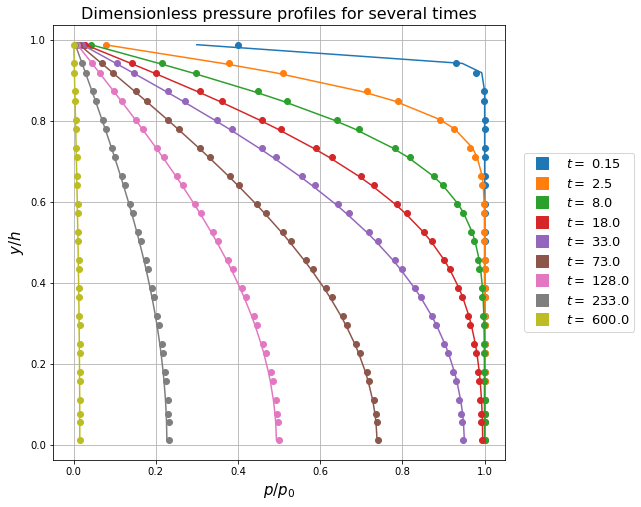

In [11]:
cmap = mcolors.ListedColormap(plt.cm.tab10.colors[: len(model.tsc.schedule)])
fig, ax = plt.subplots(figsize=(9, 8))

for idx, t in enumerate(model.tsc.schedule[1:]):
    ax.plot(
        model.sol[t]["dimless_p_ex"], 
        utils.dimless_y, 
        color=cmap.colors[idx]
    )
    ax.plot(
        model.sol[t]["dimless_p_num"], 
        utils.dimless_y, 
        color=cmap.colors[idx],
        linewidth=0,
        marker=".",
        markersize=12,
    )
    ax.plot(
        [],
        [],
        color=cmap.colors[idx],
        linewidth=0,
        marker="s",
        markersize=12,
        label=rf"$t =$ {t}",
    )
ax.set_xlabel(r"$p/p_0$", fontsize=15)
ax.set_ylabel(r"$y/h$", fontsize=15)
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc="center right", bbox_to_anchor=(1.30, 0.5), fontsize=13)
ax.set_title("Dimensionless pressure profiles for several times", fontsize=16)
ax.grid()
plt.show()

To check the mechanical response, we now focus our attention to the degree of consolidation.

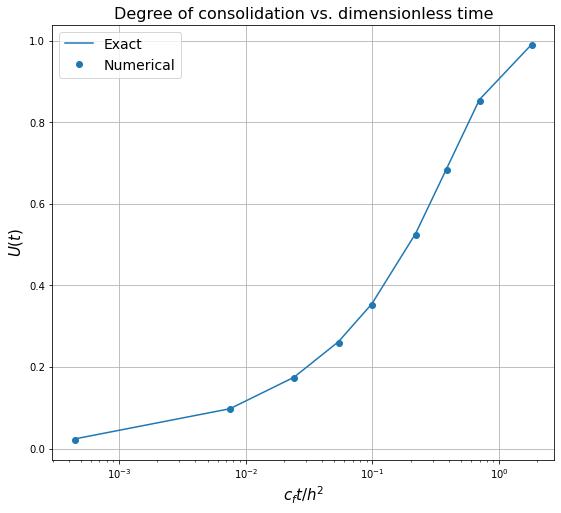

In [12]:
consol_deg_ex = np.asarray([model.sol[t]["consol_deg_ex"] for t in model.tsc.schedule[1:]])
consol_deg_num = np.asarray([model.sol[t]["consol_deg_num"] for t in model.tsc.schedule[1:]])
dimless_times = np.asarray([model.sol[t]["dimless_t"] for t in model.tsc.schedule[1:]])

fig, ax = plt.subplots(figsize=(9, 8))
ax.semilogx(
    dimless_times, 
    consol_deg_ex, 
    color=cmap.colors[0], 
    label="Exact"
)
ax.semilogx(
    dimless_times,
    consol_deg_num,
    color=cmap.colors[0],
    linewidth=0,
    marker=".",
    markersize=12,
    label="Numerical",
)
ax.set_xlabel(r"$c_f t / h^2$", fontsize=15)
ax.set_ylabel(r"$U(t)$", fontsize=15)
ax.legend(fontsize=14)
ax.set_title("Degree of consolidation vs. dimensionless time", fontsize=16)
ax.grid()
plt.show()

## What have we done?

* We showed how the standard `ContactMechanicsBiot` model can be modified to build another
models. In this case, we studied Terzaghi's consolidation model.
* The approximated pressures obtained with MPFA/MPSA-FV showed good agreement with the exact
solutions in several stages of the consolidation process.
* The mechanical responses are also well-captured as comparing the exact and numerical degrees of consolidation.